In [1]:
from utils.mlp import MLP
from utils.evaluation import mlp_eval, mlp_eval_augmented, Q_class

In [2]:
import torch

In [3]:
import numpy as np
import gsd.hoomd
import rowan
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

rainbow = mpl.colormaps['rainbow']
magma = mpl.colormaps['magma']
fontsize=50
plt.rcParams["font.family"] = "Helvetica"

# Load testing trajectory. And specify parameters.

In [4]:
fn = "data/cubes_test.gsd"
D_theta = 2
D_phi = 4
start_f = 0
N_chosen_frame = 55

traj = gsd.hoomd.open(fn)
end_f = len(traj)
print(end_f)
chosen_frame = np.linspace(start_f, end_f - 1, N_chosen_frame, dtype=int).tolist()

2200


# Calculate the reference Steinhardt order parameter $Q_6$ for comparison

In [5]:
q4 = Q_class(
    num_neighbors=6,
    traj_fn=fn,
    chosen_frame=chosen_frame,
    l=4,
    th=0.51,
)

# Test MLP classifier trained on non-augmented data

In [6]:
num_beighbors = 6
n_feat = (1+4+2)*num_beighbors
hidden = 256
n_class = 2
dropout = 0.0

model = MLP(n_feat=n_feat, nn_dim=hidden, n_class=n_class, dropout=dropout)
model.load_state_dict(torch.load('mlp_model.pth', map_location="cpu"))

mlp_ops = mlp_eval(
    num_neighbors=num_beighbors,
    traj_fn=fn,
    chosen_frame=chosen_frame,
    model=model,
    n_class=n_class
)


# Test MLP classifier trained on augmented data

In [7]:
model = MLP(n_feat=n_feat, nn_dim=hidden, n_class=n_class, dropout=dropout)
model.load_state_dict(torch.load('./mlp_model_augmented.pth', map_location="cpu"))

mlp_ops_augmented = mlp_eval_augmented(
    num_neighbors=num_beighbors,
    traj_fn=fn,
    chosen_frame=chosen_frame,
    model=model,
    n_class=n_class,
    D_theta=D_theta,
    D_phi=D_phi
)


# Plot testing results

(-0.1, 1.2)

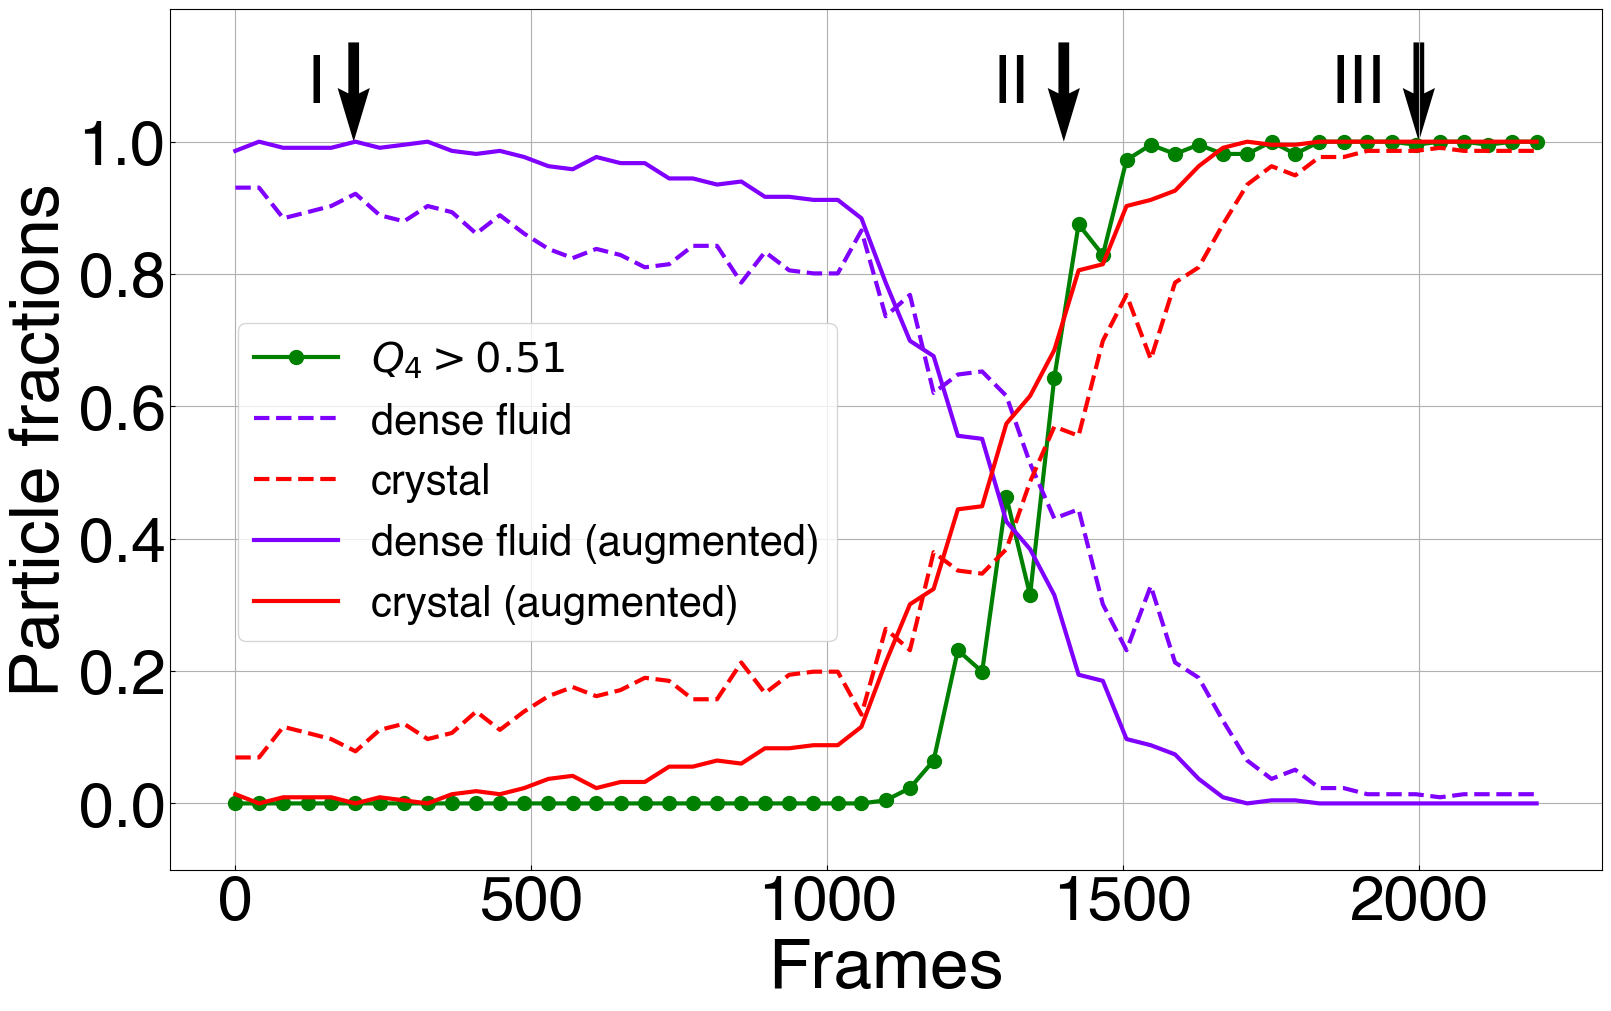

In [8]:
legend_list = ['dense fluid', 'crystal']
fig, ax = plt.subplots(figsize=(16, 10), constrained_layout=True)
ax.grid()

ax.plot(chosen_frame, q4, 'g-o', markersize=10, label=r'$Q_4 > 0.51$', linewidth=3)
ax.plot(chosen_frame, mlp_ops[:, 0], "--", label=f'{legend_list[0]}', color=rainbow(0.0), linewidth=3)
ax.plot(chosen_frame, mlp_ops[:, 1], "--", label=f'{legend_list[1]}', color=rainbow(1.0), linewidth=3)
ax.plot(chosen_frame, mlp_ops_augmented[:, 0], "-", label=f'{legend_list[0]} (augmented)', color=rainbow(0.0), linewidth=3)
ax.plot(chosen_frame, mlp_ops_augmented[:, 1], "-", label=f'{legend_list[1]} (augmented)', color=rainbow(1.0), linewidth=3)

ax.quiver(200, 1.15, 0, -0.15, scale_units='y', scale=1)
ax.quiver(1400, 1.15, 0, -0.15, scale_units='y', scale=1)
ax.quiver(2000, 1.15, 0, -0.15, scale_units='y', scale=1)
ax.text(120, 1.06, "I", fontsize=48)
ax.text(1280, 1.06, "II", fontsize=48)
ax.text(1850, 1.06, "III", fontsize=48)
ax.set_xlabel("Frames", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-5, direction="in")
ax.set_ylabel("Particle fractions", fontsize=fontsize)
ax.set_yticks(np.linspace(0, 1 ,6))
ax.tick_params(axis='y', labelsize=fontsize-5, direction="in")
ax.legend(fontsize=fontsize-20, bbox_to_anchor=(0.48, 0.66), ncol=1)
ax.set_ylim(-0.1, 1.2)

#plt.savefig("cube_test.png", dpi=300)